ARIMA EVO

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import funcs_for_proc
from transformator import (
    relative_concentration, get_accepted_maximum_value,
    get_all_relative_concentration)
import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from itertools import product
from tqdm import tqdm

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
data = funcs_for_proc.get_data_from_csv('final_data/data_train/data_train', 'csv','final_data/train.csv')


In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
for file in data[:10]:
    fig, ax = plt.subplots(4, 1, figsize=(21, 21))
    fig.suptitle(file[0], fontsize=16)
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        datetime_pred= pd.date_range("2020-01-01", periods=pred, freq='12H')
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        maximum_level = get_accepted_maximum_value(gas, 0, '220kW')[1]
        max_axhspan_level = max(data_normal[gas].max(),maximum_level)*1.05

        max_text_level = (max_axhspan_level - maximum_level) / 2 + maximum_level
        accepted_text_level = (maximum_level - accepted_level) / 2 + accepted_level
        normal_text_level = accepted_level / 2
        text_egle = round(len(data_normal.index) * 0.90) 
        # Графики
        ax[i].vlines(datetime_pred[-1], 0, max_axhspan_level,
          color = 'r',
          linewidth = 2,
          linestyle = '--')
        ax[i].plot(data_normal.index, data_normal[gas], label=pred, color='green') 
        # Зоны
        ax[i].axhspan(0, accepted_level, facecolor='1', color='green', alpha=0.3)
        ax[i].axhspan(accepted_level, maximum_level, facecolor='1', color='yellow', alpha=0.3)
        ax[i].axhspan(maximum_level, max_axhspan_level, facecolor='1', color='red', alpha=0.3)
#         Текст
        ax[i].text(data_normal.index[text_egle], max_text_level, "Предотказное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], accepted_text_level, "Развитие дефекта", fontsize=12, color='black',
                  bbox=props)
        ax[i].text(data_normal.index[text_egle], normal_text_level, "Нормальное состояние", fontsize=12, color='black',
                  bbox=props)
        ax[i].set_xlabel("Время", fontsize=12)
        ax[i].set_ylabel(f'Концентрация {gas}', fontsize=12)
        ax[i].legend()

    plt.show()

In [ ]:
for file in data[:1]:
    data_normal=file[2]
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        print("Dickey-Fuller test %s" %gas,sm.tsa.stattools.adfuller(data_normal[gas]))
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()


In [ ]:
for file in data[:1]:
    data_normal=file[2].diff(periods=1).dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



In [ ]:
for file in data[:1]:
    data_normal=file[2].diff().dropna().diff().dropna()
    pred=file[1]
    for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
        plt.figure(figsize=(21, 21))
        restest=sm.tsa.stattools.adfuller(data_normal[gas])
        print("Dickey-Fuller test %s  %f" %(gas,restest[1]))
        if restest[0]> restest[4]['5%']: 
            print ('unstat')
        else:
            print('stat')
        sm.tsa.seasonal_decompose(data_normal[gas]).plot()
        plt.show()



In [ ]:
file=data[30]
data_normal=file[2]
mindfGas=pd.DataFrame()
model_res={}
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    df=pd.DataFrame(columns=['aic','param','param_seasonal'])
    p  = q = range(0, 2)
    d=[2]
    pdq = list(product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 1) for x in pdq]
    warnings.filterwarnings("ignore") 
    aics=[]
    params=[]
    param_seasonals=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                                order=param,
                                                
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                aics.append(results.aic)
                params.append(param)
                param_seasonals.append(param_seasonal)
            except BaseException as e :
                continue
    df=pd.DataFrame({'aic':aics,'param':params,'param_seasonal':param_seasonals})
    minaic_param=df[df.aic == df.aic.min()].iloc[[0]]
    print(minaic_param)
    print(minaic_param.param.values,minaic_param.param_seasonal.values)
    mod = sm.tsa.statespace.SARIMAX(data_normal[gas],
                                order=minaic_param.param.values[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    model_res[gas] = mod.fit()

    print(model_res[gas].summary().tables[1])

In [ ]:
for i, gas in enumerate (['H2', 'CO', 'C2H4', 'C2H2']):
    print('----------------------------------------------------\nGAS %s'%gas)
    model_res[gas].plot_diagnostics(figsize=(18, 8))
    model_forecast=model_res[gas]
    plt.show()

In [ ]:
for file in data[:10]:
    models=funcs_for_proc.find_best_arima_model_for_gas(file)
    funcs_for_proc.plot_predict(file,models)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-7982.947, Time=0.35 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-8861.574, Time=0.08 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-8222.248, Time=0.14 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=-7897.026, Time=0.44 sec
 ARIMA(0,3,0)(0,0,0)[0] intercept   : AIC=-7727.184, Time=0.37 sec

Best model:  ARIMA(0,3,0)(0,0,0)[0]          
Total fit time: 1.396 seconds
Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-8404.705, Time=1.17 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-7963.585, Time=0.04 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-8053.231, Time=0.14 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=-7314.482, Time=0.33 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=-8042.592, Time=0.86 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=-7188.672, Time=0.46 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AI

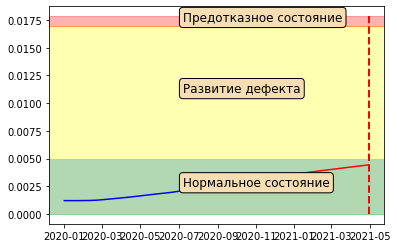

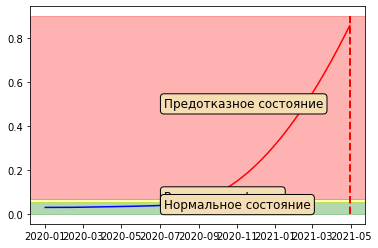

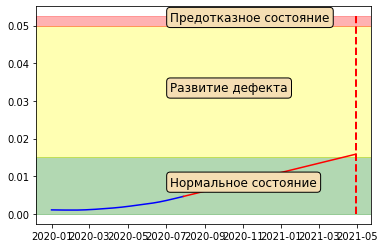

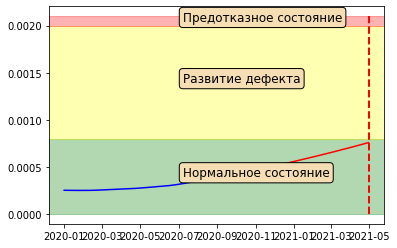

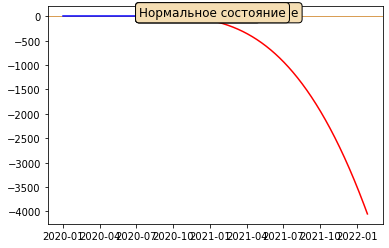

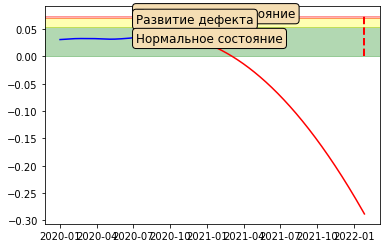

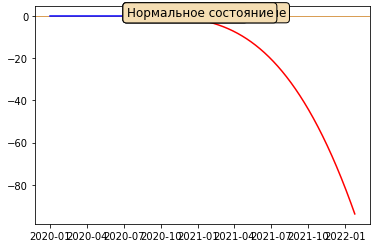

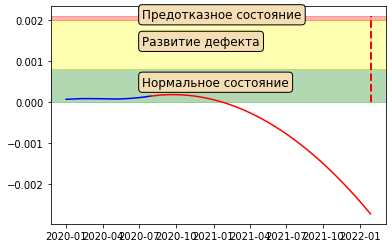

In [3]:
import funcs_for_proc
for file in data[:2]:
    models=funcs_for_proc.auto_arima(file)
    funcs_for_proc.plot_predict_auto_arima(file,models)

In [7]:
import funcs_for_proc
from sklearn.metrics import mean_absolute_error
import pmdarima as pm
def predict_time_st(models, file):
    time_gas_ar = []
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        # n=1
        # while models[gas].predict(n_periods=n)[-1]<accepted_level and n<1500:
        #     n+=1
        pered_val = models[gas].predict(n_periods=1500)
        time_gas = np.argwhere(pered_val > accepted_level)
        if time_gas.size==0:
            stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
                                         start_P=0, seasonal=False, trace=False,
                                         error_action='ignore',
                                         suppress_warnings=True,
                                         stepwise=True, n_jobs=8)
            pered_val = stepwise_fit.predict(n_periods=1500)
            time_gas = np.argwhere(pered_val > accepted_level)
            if time_gas.size==0:
                stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
                                         start_P=0, seasonal=False, trace=False,
                                         error_action='ignore',
                                         suppress_warnings=True,
                                         stepwise=True, n_jobs=8)
                pered_val = stepwise_fit.predict(n_periods=1500)
                time_gas = np.argwhere(pered_val > accepted_level)
                if time_gas.size==0:
                    return 500
            else:
                time_gas=time_gas.min()
        else:
            time_gas=time_gas.min()
        time_gas_ar.append(time_gas)
    return np.min(time_gas_ar)
df=pd.DataFrame(columns=['fimename','true','pred'])
data_for_an=data[:20]
pbar = tqdm(total=len(data_for_an))
for i,file in enumerate(data_for_an):
    models=funcs_for_proc.auto_arima(file)
    df.loc[i]=[file[0],file[1],predict_time_st(models,file)]
    pbar.update(1)
pbar.close()



  5%|▌         | 1/20 [03:15<1:01:53, 195.43s/it]

 20%|██        | 4/20 [01:35<06:01, 22.61s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 25%|██▌       | 5/20 [01:57<05:36, 22.44s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1

 30%|███       | 6/20 [02:24<05:37, 24.11s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\tran

In [10]:
df.head(20)

,fimename,true,pred
0,2_trans_497.csv,550,52
1,2_trans_483.csv,1093,256
2,2_trans_2396.csv,861,59
3,2_trans_1847.csv,1093,500
4,2_trans_2382.csv,488,61
5,2_trans_2369.csv,734,500
6,2_trans_454.csv,658,136
7,2_trans_1660.csv,533,85
8,2_trans_332.csv,713,211
9,2_trans_326.csv,496,69


In [9]:
print(mean_absolute_error(df.true,df.pred))

524.05


In [12]:
data_evo = funcs_for_proc.get_data_from_csv('final_data/data_test/data_test', 'csv',False)

In [13]:
def predict_time_st(models, file):
    time_gas_ar = []
    for i, gas in enumerate(['H2', 'CO', 'C2H4', 'C2H2']):
        accepted_level = get_accepted_maximum_value(gas, 0, '220kW')[0]
        # n=1
        # while models[gas].predict(n_periods=n)[-1]<accepted_level and n<1500:
        #     n+=1
        pered_val = models[gas].predict(n_periods=1500)
        time_gas = np.argwhere(pered_val > accepted_level)
        if time_gas.size==0:
            stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
                                         start_P=0, seasonal=False, trace=False,
                                         error_action='ignore',
                                         suppress_warnings=True,
                                         stepwise=True, n_jobs=8)
            pered_val = stepwise_fit.predict(n_periods=1500)
            time_gas = np.argwhere(pered_val > accepted_level)
            if time_gas.size==0:
                stepwise_fit = pm.auto_arima(file[2][gas], start_p=1, start_q=1, max_p=2, max_q=2, max_d=2,
                                         start_P=0, seasonal=False, trace=False,
                                         error_action='ignore',
                                         suppress_warnings=True,
                                         stepwise=True, n_jobs=8)
                pered_val = stepwise_fit.predict(n_periods=1500)
                time_gas = np.argwhere(pered_val > accepted_level)
                if time_gas.size==0:
                    return 500
            else:
                time_gas=time_gas.min()
        else:
            time_gas=time_gas.min()
        time_gas_ar.append(time_gas)
    return np.min(time_gas_ar)
df=pd.DataFrame(columns=['id','predicted'])
data_for_an=data_evo
pbar = tqdm(total=len(data_for_an))
for i,file in enumerate(data_for_an):
    models=funcs_for_proc.auto_arima(file)
    df.loc[i]=[file[0],predict_time_st(models,file)]
    pbar.update(1)
pbar.close()


  0%|          | 0/900 [00:00<?, ?it/s]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
  0%|          | 2/900 [01:15<10:29:29, 42.06s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by ze

d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
  7%|▋         | 66/900 [30:54<6:45:10, 29.15s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
  7%|▋         | 67/900 [31:26<6:56:45, 30.02s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
  8%|▊         | 68/900 [32:03<7:25:08, 32.10s/it]d:\projects\transformer\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\projects\transformer\venv\lib\site-packages\statsmodels

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').